In [1]:
import numpy as np
import torch
from transformers import AutoTokenizer
from tqdm.autonotebook import tqdm
from datasets import load_dataset
import matplotlib.pyplot as plt

from pathlib import Path
import sys

project_root = Path.cwd().parent  # adjust if llms-entropy isn’t directly under the project root
sys.path.append(str(project_root / "gpt-circuits"))

from model import GPT, GPTConfig

/scratch/gpfs/WBIALEK/ls1546/.conda/envs/gpt-circuits/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
out_dir = '/scratch/gpfs/WBIALEK/ls1546/gpt-circuits/out/shard1_m1337_d1337/'
model_ckpt = f'{out_dir}1756086913.6403742_ckpt_47000.pt'
init_from = 'scratch'

# model
dropout = 0.0
bias = False
backend = 'nccl'
device = 'cuda'
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
block_size = 2048
n_layer = 24
n_head = 16
n_embd = 2048
z_loss = 1e-4

In [3]:
# load model checkpoint and see if inference output is reasonable
checkpoint = torch.load(model_ckpt, map_location=device)
checkpoint_model_args = checkpoint['model_args']
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=50277, dropout=dropout, z_loss=z_loss) # start with model_args from command line

for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
    model_args[k] = checkpoint_model_args[k]
# create the model
gptconf = GPTConfig(**model_args)
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)

number of parameters: 1713.78M


<All keys matched successfully>

In [4]:
tok_model = "EleutherAI/gpt-neox-20b"
seqlen=2048
tokenizer = AutoTokenizer.from_pretrained(tok_model, use_fast=True)
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token
model.load_state_dict(state_dict)
model.to(device)
model.eval();

In [5]:
bos_token_id = tokenizer.bos_token_id
print(f"The BOS token ID is: {bos_token_id}")

The BOS token ID is: 0


In [ ]:
X = 0
X = torch.tensor([[bos_token_id]], dtype=torch.long).to(device)
print(X.shape)

with torch.no_grad():
    logits, _ = model(X) # BxTxV

torch.Size([1, 1])


In [ ]:
# print the top k most likely tokens
k = 10
probs = torch.softmax(logits[0, -1], dim=-1) # V
topk_probs, topk_indices = torch.topk(probs, k)
print(f"Top {k} tokens:")
for i in range(k):
    token_id = topk_indices[i].item()
    token_prob = topk_probs[i].item()
    token_str = tokenizer.decode([token_id])
    print(f"Token: {repr(token_str)} (ID: {token_id}) - Probability: {token_prob:.6f}")

Top 10 tokens:
Token: '\n' (ID: 187) - Probability: 0.071425
Token: 'The' (ID: 510) - Probability: 0.037720
Token: 'A' (ID: 34) - Probability: 0.023564
Token: 'I' (ID: 42) - Probability: 0.021751
Token: '  ' (ID: 50276) - Probability: 0.019138
Token: 'In' (ID: 688) - Probability: 0.012839
Token: '    ' (ID: 50274) - Probability: 0.009627
Token: 'What' (ID: 1276) - Probability: 0.009296
Token: 'As' (ID: 1909) - Probability: 0.007600
Token: 'But' (ID: 1989) - Probability: 0.007384


In [8]:
probs.mean()

tensor(1.9890e-05, device='cuda:0')

In [10]:
probs.shape

torch.Size([50277])

In [13]:
# calculate the entropy of the distribution in bits
entropy = -torch.sum(probs * torch.log2(probs)).item()
entropy

9.644674301147461

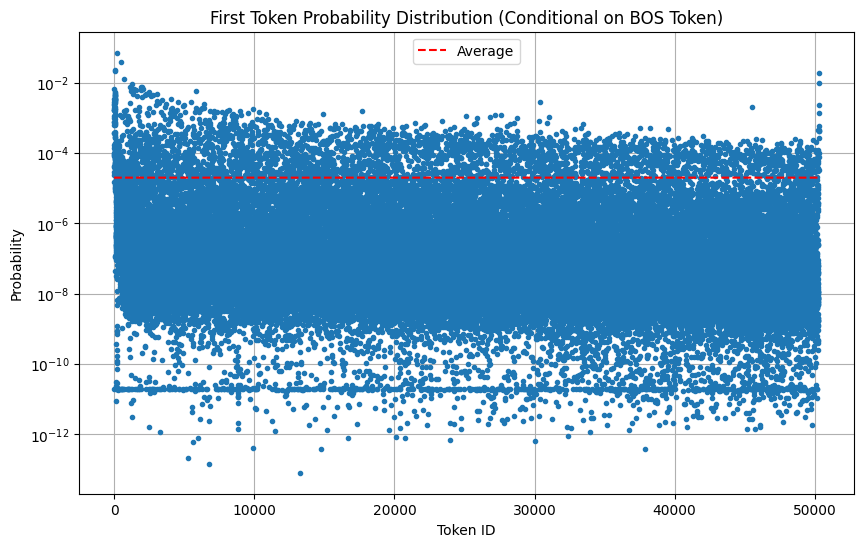

In [ ]:
# how does the distribution look?
plt.figure(figsize=(10, 6))
plt.plot(probs.cpu().numpy(), marker='.', linestyle='None')
# plot average line
plt.plot(torch.arange(probs.shape[-1]), [probs.mean().cpu().numpy()] * len(probs), 'r--', label='Average')
plt.legend()
plt.yscale('log')
plt.title('First Token Probability Distribution (Conditional on BOS Token)')
plt.xlabel('Token ID')
plt.ylabel('Probability')
plt.grid(True)
plt.legend(loc='upper center')
plt.savefig('token_probability_distribution.pdf')

In [16]:
max(probs)

tensor(0.0714, device='cuda:0')

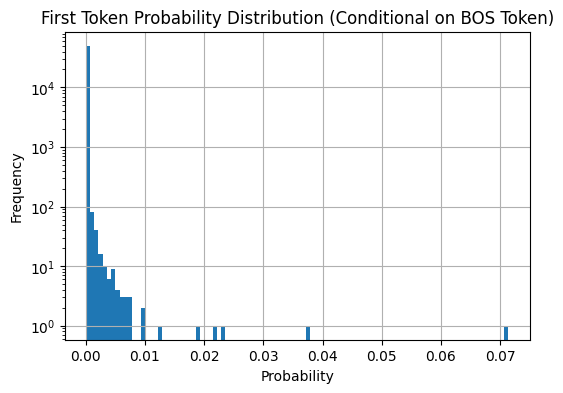

In [18]:
# make a histogram of the probabilities
plt.figure(figsize=(6, 4))
plt.hist(probs.cpu().numpy(), bins=100, log=True)
plt.title('First Token Probability Distribution (Conditional on BOS Token)')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.ylim
plt.grid(True)
plt.savefig('token_probability_histogram.pdf')

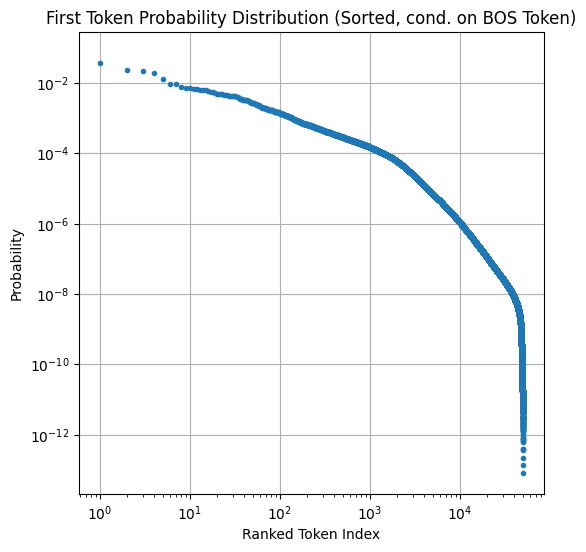

In [25]:
# plot the distribution again but sort the token ids by their probabilities
plt.figure(figsize=(6, 6))
sorted_probs, _ = torch.sort(probs, descending=True)
plt.plot(sorted_probs.cpu().numpy(), marker='.', linestyle='None')
plt.yscale('log')
plt.xscale('log')
plt.title('First Token Probability Distribution (Sorted, cond. on BOS Token)')
plt.xlabel('Ranked Token Index')
plt.ylabel('Probability')
plt.grid(True)
plt.savefig('token_probability_sorted.pdf')

In [17]:
X_raw = "When Mary and John went to the store, John gave a drink to"
X = tokenizer(X_raw, return_tensors='pt', padding=True, truncation=True, max_length=seqlen)
X = X['input_ids'].to(device)
Y_raw = "Mary and John went to the store, John gave a drink to Mary"
Y = tokenizer(Y_raw, return_tensors='pt', padding=True, truncation=True, max_length=seqlen)
Y = Y['input_ids'].to(device)
with torch.no_grad():
    logits, _ = model(X, Y) # BxTxV
    # if Y is none, then Bx1xV, only gives the logits of last token

In [18]:
# convert logits to text outputs
# logits = logits[:, -1, :]  # take the last token's logits
predicted_ids = torch.argmax(logits, dim=-1)
output_text = tokenizer.decode(predicted_ids[0], skip_special_tokens=True)
print(output_text)

 you was I were to the temple, they said Mary little to Mary


In [19]:
logits.shape

torch.Size([1, 14, 50277])

In [20]:
# interweave the input and outputs for each token generated to visualize why entropy is high or low
input_ids = X[0].detach().cpu().numpy()
output_ids = predicted_ids[0].detach().cpu().numpy()
rows = []
for i in range(1, len(output_ids)):
    prefix = input_ids[:i]
    seq = np.concatenate([prefix[:i], [output_ids[i-1]]]).tolist()
    rows.append(seq)

for i, seq in enumerate(rows):
    print(i, tokenizer.decode(seq, skip_special_tokens=True))

0 When you
1 When Mary was
2 When Mary and I
3 When Mary and John were
4 When Mary and John went to
5 When Mary and John went to the
6 When Mary and John went to the temple
7 When Mary and John went to the store,
8 When Mary and John went to the store, they
9 When Mary and John went to the store, John said
10 When Mary and John went to the store, John gave Mary
11 When Mary and John went to the store, John gave a little
12 When Mary and John went to the store, John gave a drink to


In [30]:
# look at the top probabilities for all tokens (these are conditional on all previous tokens)
top_probs, top_ids = torch.topk(logits, k=10, dim=-1)
top_probs = torch.softmax(top_probs, dim=-1)
for i in range(top_probs.shape[1]):
    print(f"Token position {i+1}:")
    for prob, id in zip(top_probs[0, i], top_ids[0, i]):
        print(f"{tokenizer.decode(id.item())}: {prob.item():.4f}")

Token position 1:
 you: 0.2676
 the: 0.1527
 they: 0.1297
 I: 0.1281
 it: 0.0889
 he: 0.0769
 we: 0.0633
 she: 0.0427
 that: 0.0262
 a: 0.0239
Token position 2:
 was: 0.2917
 and: 0.1796
 had: 0.1110
's: 0.1063
 is: 0.0737
,: 0.0600
 said: 0.0475
 asked: 0.0459
 Jane: 0.0434
 Shel: 0.0408
Token position 3:
 I: 0.4019
 Joseph: 0.1230
 her: 0.1200
 John: 0.1108
 the: 0.0596
 William: 0.0512
 Robert: 0.0392
 Peter: 0.0339
 Joe: 0.0327
 Paul: 0.0277
Token position 4:
 were: 0.4050
 came: 0.1283
 had: 0.1282
 arrived: 0.0714
 are: 0.0581
 left: 0.0576
 got: 0.0419
 went: 0.0409
 met: 0.0362
 moved: 0.0323
Token position 5:
 to: 0.6994
 out: 0.0625
 into: 0.0579
 back: 0.0563
 up: 0.0321
 on: 0.0274
 home: 0.0233
 down: 0.0153
 for: 0.0130
 through: 0.0129
Token position 6:
 the: 0.4888
 visit: 0.1489
 see: 0.0951
 Beth: 0.0689
 live: 0.0462
 church: 0.0413
 meet: 0.0363
 their: 0.0279
 bed: 0.0251
 get: 0.0215
Token position 7:
 temple: 0.2908
 hospital: 0.1599
 wedding: 0.1104
 market: 0.0

In [10]:
# since the each logit is conditional on all previous tokens, we can look at the entropy of the distribution
probs = torch.softmax(logits, dim=-1)
log_probs = torch.log(probs + 1e-10)
entropy = -torch.sum(probs * log_probs, dim=-1) # BxT
entropy = entropy.detach().cpu().numpy()
print(entropy)

[[4.7217526 6.299671  5.166932  5.5848646 1.9224327 4.395483  6.17684
  2.4847572 3.4960482 4.541564  1.9163743 5.8428593 1.1458027 2.0154262]]


Text(0.5, 1.0, 'Conditional Entropy vs Token Position')

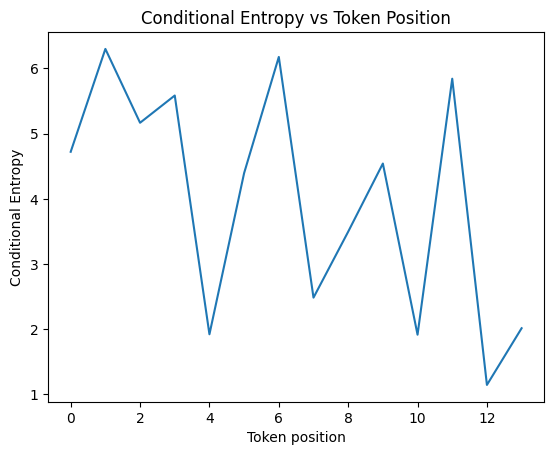

In [ ]:
# plot the conditional entropy vs token position
plt.plot(entropy[0])
plt.xlabel('Token position')
plt.ylabel('Conditional Entropy')
plt.title('Conditional Entropy vs Token Position')

In [5]:
# now do this over real data as the input
# read in a json file of text data
c4path = '/scratch/gpfs/DATASETS/hugging_face/c4/en'
dataset = load_dataset('json', data_files=f'{c4path}/c4-train.00000-of-01024.json', split='train')

In [6]:
# now repeat entropy calculation over real data
texts = dataset['text']  
text = texts[0]
text

'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.'

In [7]:
len(texts)

356317

In [8]:
# now repeat entropy calculation over real data
texts = dataset['text'][:1024]  
# make batches of data where each batch is tokenized and truncated to seqlen
total_entropy = 0.0
total_tokens = 0
pos_sum = None
pos_count = None
bs = 8
for i in (pbar := tqdm(range(0, len(texts), bs))):
    text = texts[i:i+bs]
    batch = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=seqlen)
    input_ids = batch['input_ids'].to(device)
    with torch.no_grad():
        target_ids = input_ids[:, 1:].contiguous()
        input_ids = input_ids[:, :-1].contiguous()
        logits, _ = model(input_ids, target_ids) # BxTxV
        attn_mask = batch['attention_mask'][:, 1:].to(device) # drop BOS/pad slot
        probs = torch.softmax(logits, dim=-1)
        log_probs = torch.log2(probs.clamp_min(1e-10))

        entropy = -torch.sum(probs * log_probs, dim=-1) # BxT
        entropy = entropy * attn_mask  # mask out padding tokens
        total_entropy += entropy.sum().item()
        total_tokens += attn_mask.sum().item()

        batch_sum = entropy.sum(dim=0)
        batch_count = attn_mask.sum(dim=0)
        if pos_sum is None or pos_sum.shape[0] < batch_sum.shape[0]:
            new_len = batch_sum.shape[0]
            pos_sum = torch.zeros(new_len)
            pos_count = torch.zeros(new_len)
        pos_sum[:batch_sum.shape[0]] += batch_sum.cpu().detach()
        pos_count[:batch_count.shape[0]] += batch_count.cpu().detach()

    dataset_avg_entropy = total_entropy / total_tokens
    per_position_avg = pos_sum / pos_count.clamp_min(1)
    pbar.set_description(f"avg entropy (bits): {dataset_avg_entropy:.4f}")

avg entropy (bits): 4.0056: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:19<00:00,  2.03s/it]


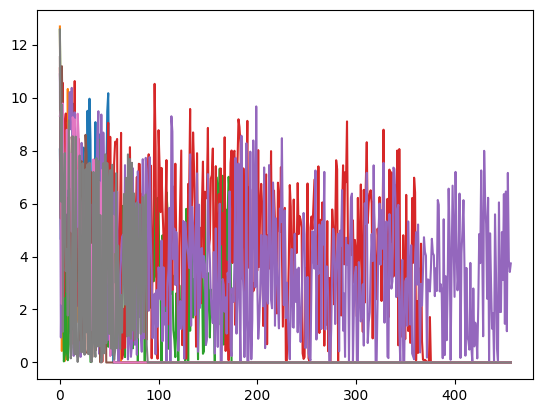

In [9]:
for i in range(entropy.shape[0]):
    plt.plot(entropy[i].cpu().numpy())

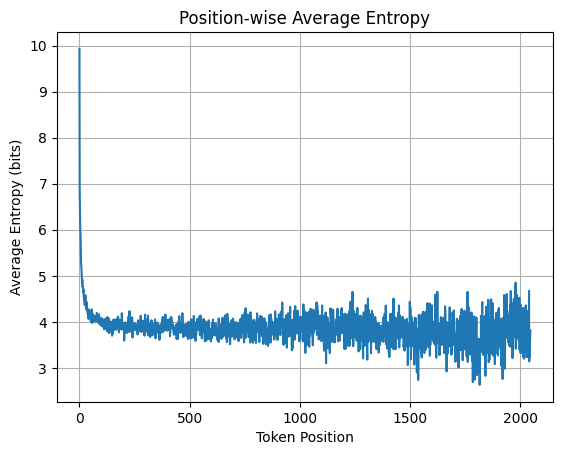

In [10]:
# plot the position-wise average entropy
plt.plot(per_position_avg.numpy())
plt.title('Position-wise Average Entropy')
plt.xlabel('Token Position')
plt.ylabel('Average Entropy (bits)')
plt.grid(True)

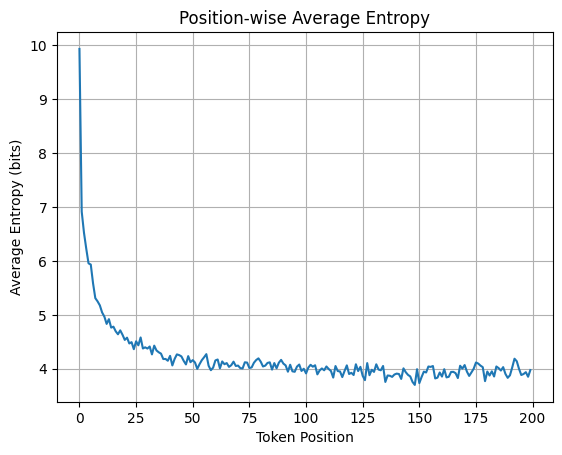

In [14]:
# plot the position-wise average entropy for first 200 tokens
plt.plot(per_position_avg.numpy()[:200])
plt.title('Position-wise Average Entropy')
plt.xlabel('Token Position')
plt.ylabel('Average Entropy (bits)')
plt.grid(True)

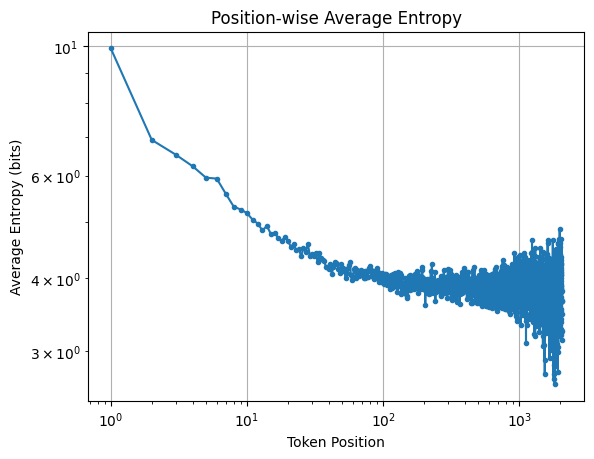

In [11]:
# plot the position-wise average entropy
plt.plot(np.arange(1, len(per_position_avg.numpy())+1), per_position_avg.numpy(), marker='.')
plt.title('Position-wise Average Entropy')
plt.xlabel('Token Position')
plt.ylabel('Average Entropy (bits)')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)

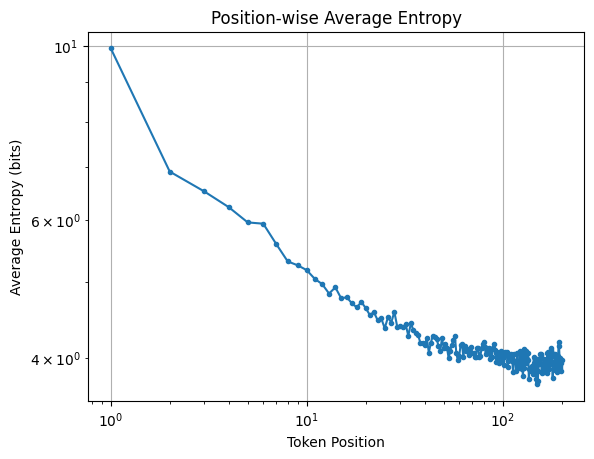

In [15]:
# plot the position-wise average entropy
plt.plot(np.arange(1, len(per_position_avg.numpy()[:200])+1), per_position_avg.numpy()[:200], marker='.')
plt.title('Position-wise Average Entropy')
plt.xlabel('Token Position')
plt.ylabel('Average Entropy (bits)')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)

In [12]:
# calculate the average num of chars per token for the data
batch_char = 0
batch_tok = 0

for i in (pbar := tqdm(range(0, len(texts), bs))):
    text = texts[i:i+bs]
    batch = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=seqlen)
    input_ids = batch['input_ids'].to(device)
    with torch.no_grad():

        attention_mask = batch['attention_mask'].to(device)

        for ids, mask in zip(input_ids, attention_mask):
            real_tokens = ids[mask.bool()]
            decoded = tokenizer.decode(real_tokens, skip_special_tokens=True, clean_up_tokenization_spaces=False)
            batch_char += len(decoded)
            batch_tok += mask.sum().item()

    avg_chars_per_token = batch_char / batch_tok
    pbar.set_description(f"avg chars per token: {avg_chars_per_token:.4f}")

avg chars per token: 4.5183: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 98.82it/s]


100000it [01:20, 1247.96it/s]


filtered chars: {np.str_('p'), np.str_('E'), np.str_('‘'), np.str_('H'), np.str_('F'), np.str_('\n'), np.str_('C'), np.str_('g'), np.str_('.'), np.str_('!'), np.str_('o'), np.str_('-'), np.str_(';'), np.str_('l'), np.str_(' '), np.str_('T'), np.str_('*'), np.str_('M'), np.str_('4'), np.str_('$'), np.str_('6'), np.str_('m'), np.str_('r'), np.str_('B'), np.str_('_'), np.str_('t'), np.str_('s'), np.str_('O'), np.str_('U'), np.str_('J'), np.str_('7'), np.str_('3'), np.str_('G'), np.str_('’'), np.str_('W'), np.str_('z'), np.str_('”'), np.str_('N'), np.str_('h'), np.str_('I'), np.str_('Y'), np.str_('2'), np.str_('a'), np.str_(']'), np.str_('?'), np.str_('A'), np.str_('('), np.str_('c'), np.str_(','), np.str_('Q'), np.str_('"'), np.str_('“'), np.str_('–'), np.str_('b'), np.str_('—'), np.str_('v'), np.str_('5'), np.str_('8'), np.str_(')'), np.str_("'"), np.str_('R'), np.str_('k'), np.str_('#'), np.str_('%'), np.str_('f'), np.str_('S'), np.str_('j'), np.str_('K'), np.str_('9'), np.str_('V'), np

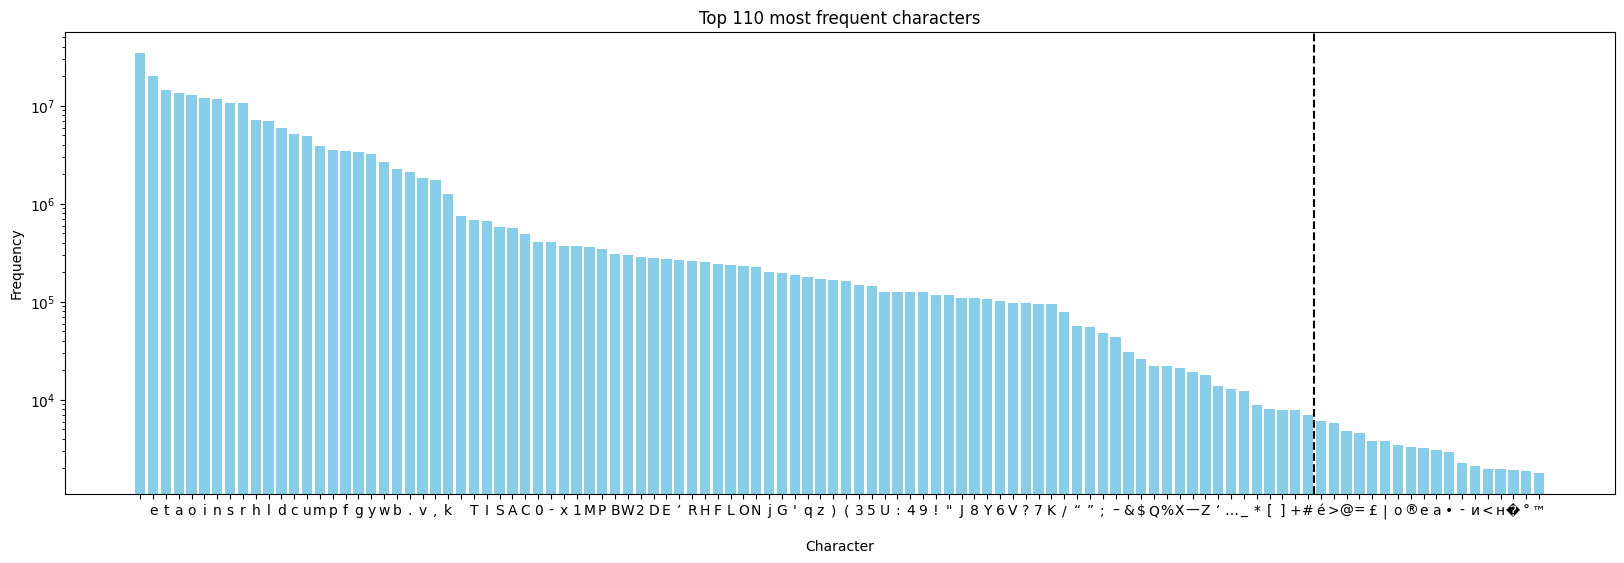

In [13]:
# special_chars = """\n!"#$%&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz–—''""…"""
import collections as collect
import json

file1='/scratch/gpfs/DATASETS/hugging_face/c4/en/c4-train.00345-of-01024.json'
with open(file1,'r') as f:
    data=[json.loads(l) for l in f]

textlist=[d['text'] for d in data]

#takes 2 minutes to run 
bigcounter=collect.Counter("")
for i,text in tqdm(enumerate(textlist[:100000])):
    bigcounter=bigcounter+collect.Counter(text)

keys,values=zip(*bigcounter.items())
inds=np.flip(np.argsort(values))
keys=np.array(keys)[inds]
values=np.array(values)[inds]

#plot results
plt.rcParams['font.family'] = 'DejaVu Sans'  # or 'DejaVu Sans Mono', etc.
fig,ax=plt.subplots(figsize=(20, 6),dpi=100)
ax.bar(keys[:110], values[:110], color='skyblue')
ax.axvline(91+0.5,color='k',ls='--')
ax.set_xlabel('Character')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
ax.set_title('Top 110 most frequent characters')

#the set of 92 characters
safeset=set(keys[:92])
print("filtered chars:", safeset)
#the filtered text
ftext=[]
for i,text in enumerate(textlist):
    if len(set(text).difference(safeset)) ==0:
        ftext.append(text)

In [11]:
# codelength: -log2(p(t_n+1 | t_1,...,t_n))
# get the codelengths at each token for each sequence in a batch of text
# avg the codelengths over all sequences at each token position
def compute_codelength(text, model, tokenizer, device, seqlen=2048):
    batch = tokenizer(text, return_tensors='pt', truncation=True, max_length=seqlen, padding=True)
    input_ids = batch['input_ids'].to(device)
    attn_mask = batch['attention_mask'].to(device)
    with torch.no_grad():
        target_ids = input_ids[:, 1:].contiguous()
        input_ids = input_ids[:, :-1].contiguous()
        logits, _ = model(input_ids, target_ids) # BxTxV
        probs = torch.softmax(logits, dim=-1)
        attn_mask = attn_mask[:, 1:]  # drop BOS/pad slot

        # Compute codelengths
        target_probs = probs.gather(-1, target_ids.unsqueeze(-1)).squeeze(-1)  # BxT
        codelengths = -torch.log2(target_probs + 1e-10)  # BxT
        codelengths = codelengths * attn_mask  # mask out padding tokens

        # sum the codelengths over batch to get total codelength per position to then avg over the codelength counts at each position
        position_codelength_sum = codelengths.sum(dim=0).cpu()
        position_codelength_count = attn_mask.sum(dim=0).cpu()
    return position_codelength_sum, position_codelength_count

In [12]:
# compute codelengths over texts and then do entropy + codelengths plots, then also do filtered text
bs = 8
total_pos_sum = None
total_pos_count = None
total_codelength = 0.0
total_tokens = 0
for i in (pbar := tqdm(range(0, len(texts), bs))):
    text = texts[i:i+bs]
    pos_codelength_sum, pos_codelength_count = compute_codelength(text, model, tokenizer, device, seqlen=2048)
    if total_pos_sum is None or total_pos_sum.shape[0] < pos_codelength_sum.shape[0]:
        new_len = pos_codelength_sum.shape[0]
        total_pos_sum = torch.zeros(new_len)
        total_pos_count = torch.zeros(new_len)
    total_pos_sum[:pos_codelength_sum.shape[0]] += pos_codelength_sum.cpu().detach()
    total_pos_count[:pos_codelength_count.shape[0]] += pos_codelength_count.cpu().detach()
    total_codelength += pos_codelength_sum.sum().item()
    total_tokens += pos_codelength_count.sum().item()

    dataset_avg_codelength = total_codelength / total_tokens
    per_position_avg = total_pos_sum / total_pos_count.clamp_min(1)
    pbar.set_description(f"avg codelength (bits): {dataset_avg_codelength:.4f}")

avg codelength (bits): 4.0754: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:16<00:00,  2.00s/it]


In [ ]:
pos_sum_ent = pos_sum
pos_count_ent = pos_count
pos_sum_codelen = total_pos_sum
pos_count_codelen = total_pos_count

In [ ]:
pos_sum_ent.shape, pos_sum_codelen.shape, pos_count_ent.shape, pos_count_codelen.shape

(torch.Size([2047]),
 torch.Size([2047]),
 torch.Size([2047]),
 torch.Size([2047]))

In [17]:
pos_count_ent[0], pos_count_codelen[0], pos_count_ent[-1], pos_count_codelen[-1]

(tensor(1016.), tensor(1016.), tensor(30.), tensor(30.))

In [18]:
per_position_avg_ent = pos_sum_ent / pos_count_ent.clamp_min(1)
per_position_avg_codelen = pos_sum_codelen / pos_count_codelen.clamp_min(1)
per_position_avg_ent.shape, per_position_avg_codelen.shape

(torch.Size([2047]), torch.Size([2047]))

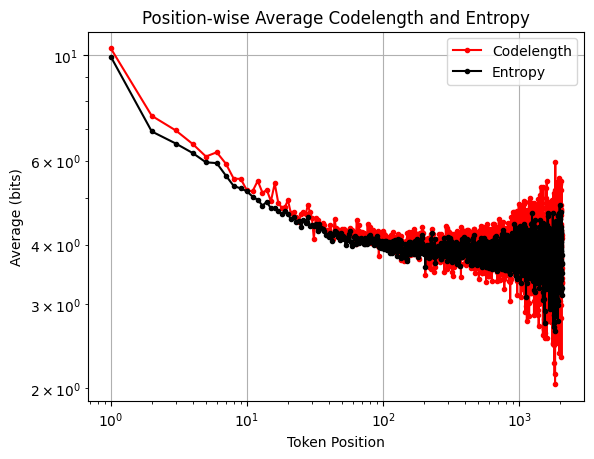

In [19]:
# plot the position-wise average codelength and entropy
plt.plot(np.arange(1, len(per_position_avg_codelen.numpy())+1), per_position_avg_codelen.numpy(), marker='.', label='Codelength', color='red')
plt.plot(np.arange(1, len(per_position_avg_ent.numpy())+1), per_position_avg_ent.numpy(), marker='.', label='Entropy', color='black')
plt.title('Position-wise Average Codelength and Entropy')
plt.xlabel('Token Position')
plt.ylabel('Average (bits)')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.legend()

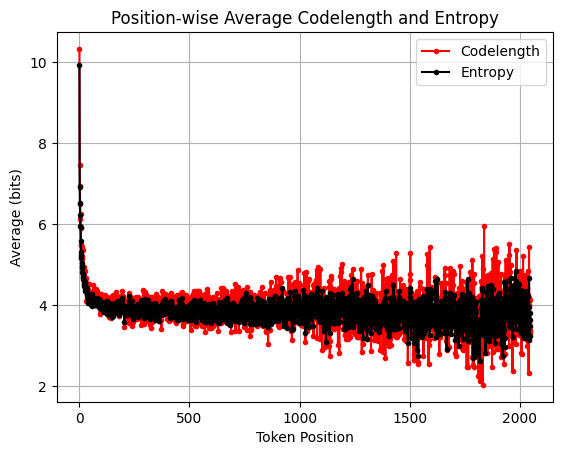

In [20]:
# plot the position-wise average codelength and entropy
plt.plot(np.arange(1, len(per_position_avg_codelen.numpy())+1), per_position_avg_codelen.numpy(), marker='.', label='Codelength', color='red')
plt.plot(np.arange(1, len(per_position_avg_ent.numpy())+1), per_position_avg_ent.numpy(), marker='.', label='Entropy', color='black')
plt.title('Position-wise Average Codelength and Entropy')
plt.xlabel('Token Position')
plt.ylabel('Average (bits)')
plt.grid(True)
plt.legend()

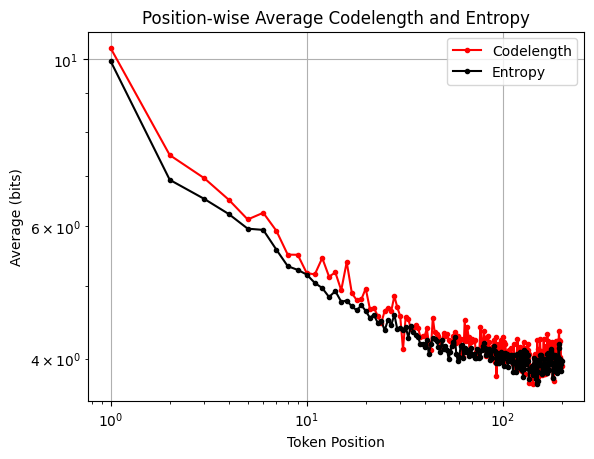

In [22]:
# plot the position-wise average codelength and entropy
plt.plot(np.arange(1, len(per_position_avg_codelen.numpy()[:200])+1), per_position_avg_codelen[:200].numpy(), marker='.', label='Codelength', color='red')
plt.plot(np.arange(1, len(per_position_avg_ent.numpy()[:200])+1), per_position_avg_ent[:200].numpy(), marker='.', label='Entropy', color='black')
plt.title('Position-wise Average Codelength and Entropy')
plt.xlabel('Token Position')
plt.ylabel('Average (bits)')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.legend()